Adapted by Carlos Toxtli https://www.carlostoxtli.com/#colab-mlp-2

Source: https://github.com/littlenine/MLP-tutorial/blob/master/MLP%20with%20MNIST.ipynb

# MLP

In this tutorial, we will use Keras and MNIST dataset.
  
  
MNIST dataset is a opensource dataset for hand writing.
Each image is in size 28 x 28 pixel.
  

Before we start get into Keras, let's prepare some visualize methods.

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image

def show_images(images: list) -> None:
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray')
    plt.show(block=True)

def show_image(image) -> None:
    plt.imshow(image, cmap='gray')
    plt.show(block=True)

def show_online_image(target_url):
    # Image(url= "https://gluon.mxnet.io/_images/dcgan.png")
    Image(url= target_url)

def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25: num=25
    for i in range(0, num):
        ax=plt.subplot(5, 5, i+1)
        ax.imshow(images[idx], cmap='binary')
        title="label=" + str(labels[idx])
        if len(prediction) > 0:
            title += ",predict=" + str(prediction[idx])
        ax.set_title(title, fontsize=10)
        ax.set_xticks([]);
        ax.set_yticks([]);
        idx += 1
    plt.show()

def show_train_history(train_history):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    print(train_history.history.keys())

    if "accuracy" in train_history.history.keys():
        plt.plot(train_history.history["accuracy"])

    if "val_accuracy" in train_history.history.keys():
        plt.plot(train_history.history["val_accuracy"])

    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)

    if "loss" in train_history.history.keys():
        plt.plot(train_history.history["loss"])

    if "val_loss" in train_history.history.keys():
        plt.plot(train_history.history["val_loss"])

    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Load and check your datas
You can load your dataset from Keras directly.
Let's check how it looks like.

11490434/11490434 [==============================] - 0s 0us/step


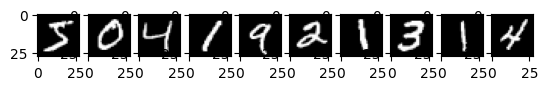

number of training images: 60000
number of test images: 10000


In [2]:
from tensorflow import keras
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# print out first 10 images in our training data
imgplot = show_images(x_train[0:10])

# check the size of our dataset
print("number of training images:",x_train.shape[0])
print("number of test images:",y_test.shape[0])

Now we know the how many images we have in training data, and we know the structure of MLP.  
  
**How to make image into MLP input?**    
Simply, we make it into a vector.

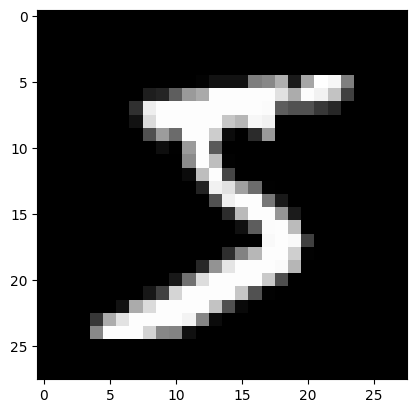

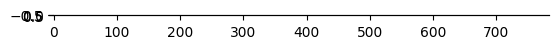

In [3]:
sample = x_train[0]

# origin image
show_image(sample)

# input of MLP, a images were transfer into a vector
show_image(sample.reshape(1, 28 * 28))

In [4]:
# update all the training, testing dataset.
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize them into range [0, 1]
x_train /= 255
x_test /= 255

**Why Normalize need to divide by 255 for image?**  

In computer vision, the color space were
R \[0,255\]
G \[0,255\]
B \[0,255\]

While we use gray images, the color space of R G B were same.  
We can take color space \[3, High, Weight\] of an image as
\[1, High, Weight\].  
Same as \[H, W\]  

## Prepare your first model  
  
In Keras, you can create model layers like a Queue.  

In [5]:
from tensorflow.keras import layers

num_classes = 10

# create a Sequential model
model = keras.Sequential(
    [
        # input layer. input data with size 28*28 and output size 256
        # 256 means you set up your modul with 256 NN in this layer. This value is up to you.
        layers.Dense(256, input_shape=(28*28,), activation='relu'),

        # hidden layer. input data with size 256, which were same to output of input layer.
        # output size 256, we set up 256 NN again in this hidden layer.
        # no need to give input size here because keras already know.
        layers.Dense(256, activation='relu'),

        # output layer. the number of output should be your number of classification
        layers.Dense(num_classes, activation='softmax')
    ]
);

# print out model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269322 (1.03 MB)
Trainable params: 269322 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**What we have in our model is:**  
input layer: input size = 28*28+1, output size = 256.  we have totally (28*28+1)* 256 = 200960 parameters.  
hidden layer: input size = 256 + 1, output size = 256. we have totally (256+1)* 256   = 65792 parameters.  
output layer:input size = 256 + 1, output size = 10.   we have totally (256+1)* 10    = 2570 parameters.  

## Compile your model
We can now move on to compile our model.  
Here are the parameters:  
- optimizer : how to optimize your weights.
- loss : loss function.
- metrics : how to evaluate your model.

we don't disscuss how to select your optimizer and loss here. :)  
Let's introduce 2 important setting in Machine Learning.
- Batch : there are 2 ways to update your weights in model  
    - update everytime after watching **an** input.
    - update once after watching **batch** of inputs.  
      
    here we update once for 1000 inputs.  
- Epochs : how many times you want to look overwhole your datas.

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 256
epochs = 10
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 9s 5ms/step - loss: 0.2146 - accuracy: 0.9354 - val_loss: 0.1242 - val_accuracy: 0.9625
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0875 - accuracy: 0.9733 - val_loss: 0.0918 - val_accuracy: 0.9721
Epoch 3/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0610 - accuracy: 0.9804 - val_loss: 0.0833 - val_accuracy: 0.9728
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0443 - accuracy: 0.9856 - val_loss: 0.0905 - val_accuracy: 0.9757
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0347 - accuracy: 0.9884 - val_loss: 0.0900 - val_accuracy: 0.9764
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.1040 - val_accuracy: 0.9742
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0263 - accuracy: 0.9910 - val_loss: 0.1012 - val_accuracy:

## Check result of model

How it works on testing data?  

In [9]:
scores, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores)
print('Test accuracy:', acc)

Test loss: 0.11870118230581284
Test accuracy: 0.9758999943733215



  
It looks nice!   
  
Let's visualize our result by printing out 25 images of label and predict result.

313/313 [==============================] - 1s 3ms/step
Test prediction: [[9.2452905e-17 6.9615730e-10 4.4605696e-13 ... 9.9999422e-01
  7.1260624e-14 5.7400712e-06]
 [4.9622081e-18 6.2901385e-12 9.9999994e-01 ... 1.6902386e-19
  6.4715101e-21 1.4690487e-26]
 [1.2766110e-07 9.9998981e-01 8.2918305e-06 ... 1.0195718e-06
  2.1637163e-07 1.8715898e-08]
 ...
 [7.2486395e-19 3.6093741e-16 4.6773758e-20 ... 2.7109009e-13
  5.5438097e-20 1.1189662e-12]
 [5.1156169e-14 1.6217124e-22 4.5360157e-18 ... 3.9508160e-19
  1.3553231e-13 2.4737845e-17]
 [5.4466617e-16 1.2812527e-20 1.6893168e-19 ... 1.3513333e-27
  7.8587845e-19 4.5549285e-20]]


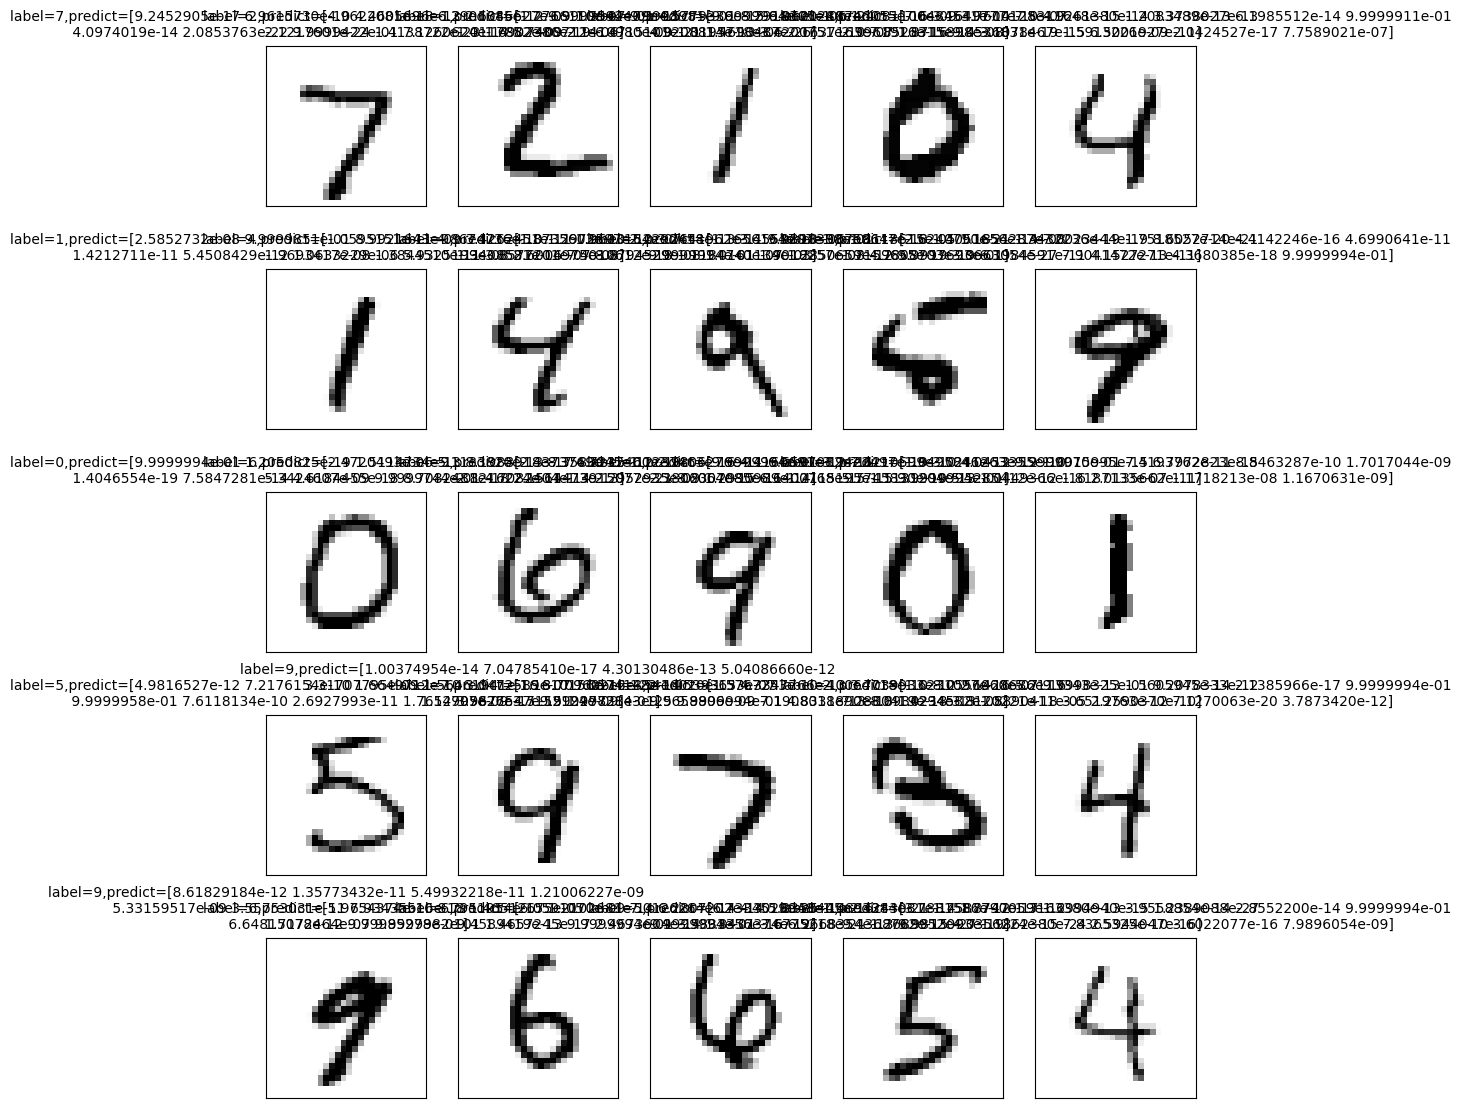

In [14]:
prediction = model.predict(x_test)
print('Test prediction:', prediction)

i = 0  # start from 0
j = 25 # end at 25

(_, _), (x_test_image, y_test_label) = mnist.load_data()
plot_images_labels_prediction(x_test_image,y_test_label,prediction,i,j)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


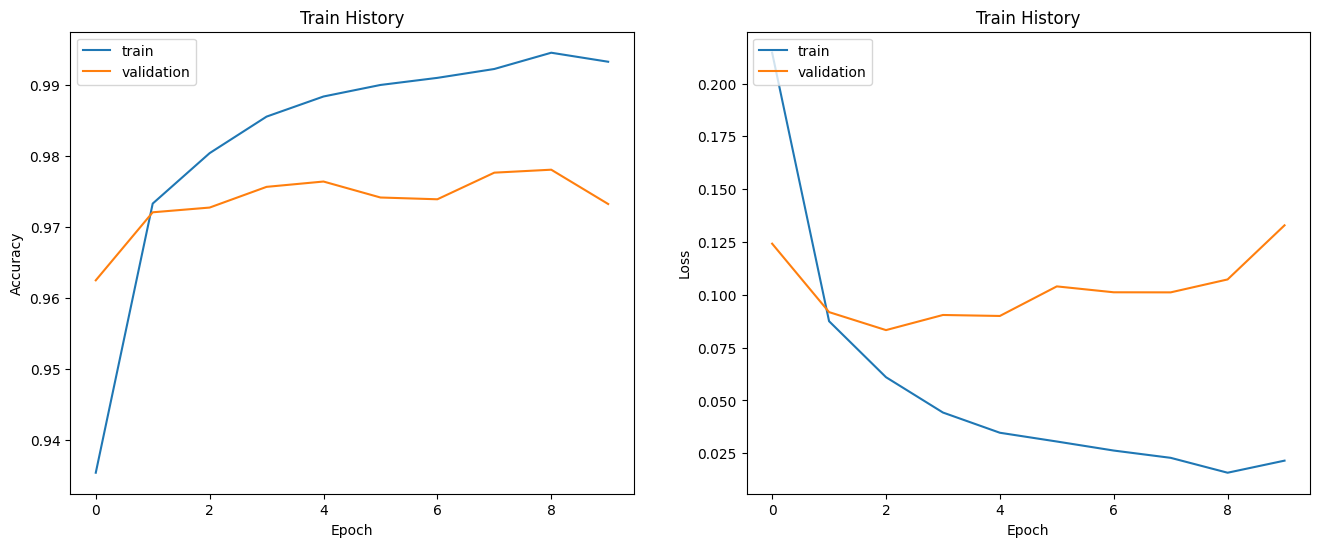

In [11]:
#show train history
show_train_history(history)